In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
sc.settings.set_figure_params(dpi=100)

In [2]:
# read in the levenshtein distance for the epitope information
df_l = pd.read_csv('../outputs/model_v3/full.epitope.levenshtein.csv', index_col=0)

In [5]:
# gather linkage and fcluster
from scipy.cluster.hierarchy import linkage
# get dendrogram information
Z = linkage(df_l.astype(float), method='ward')

/tmp/ipykernel_38871/1790401596.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(df_l.astype(float), method='ward')


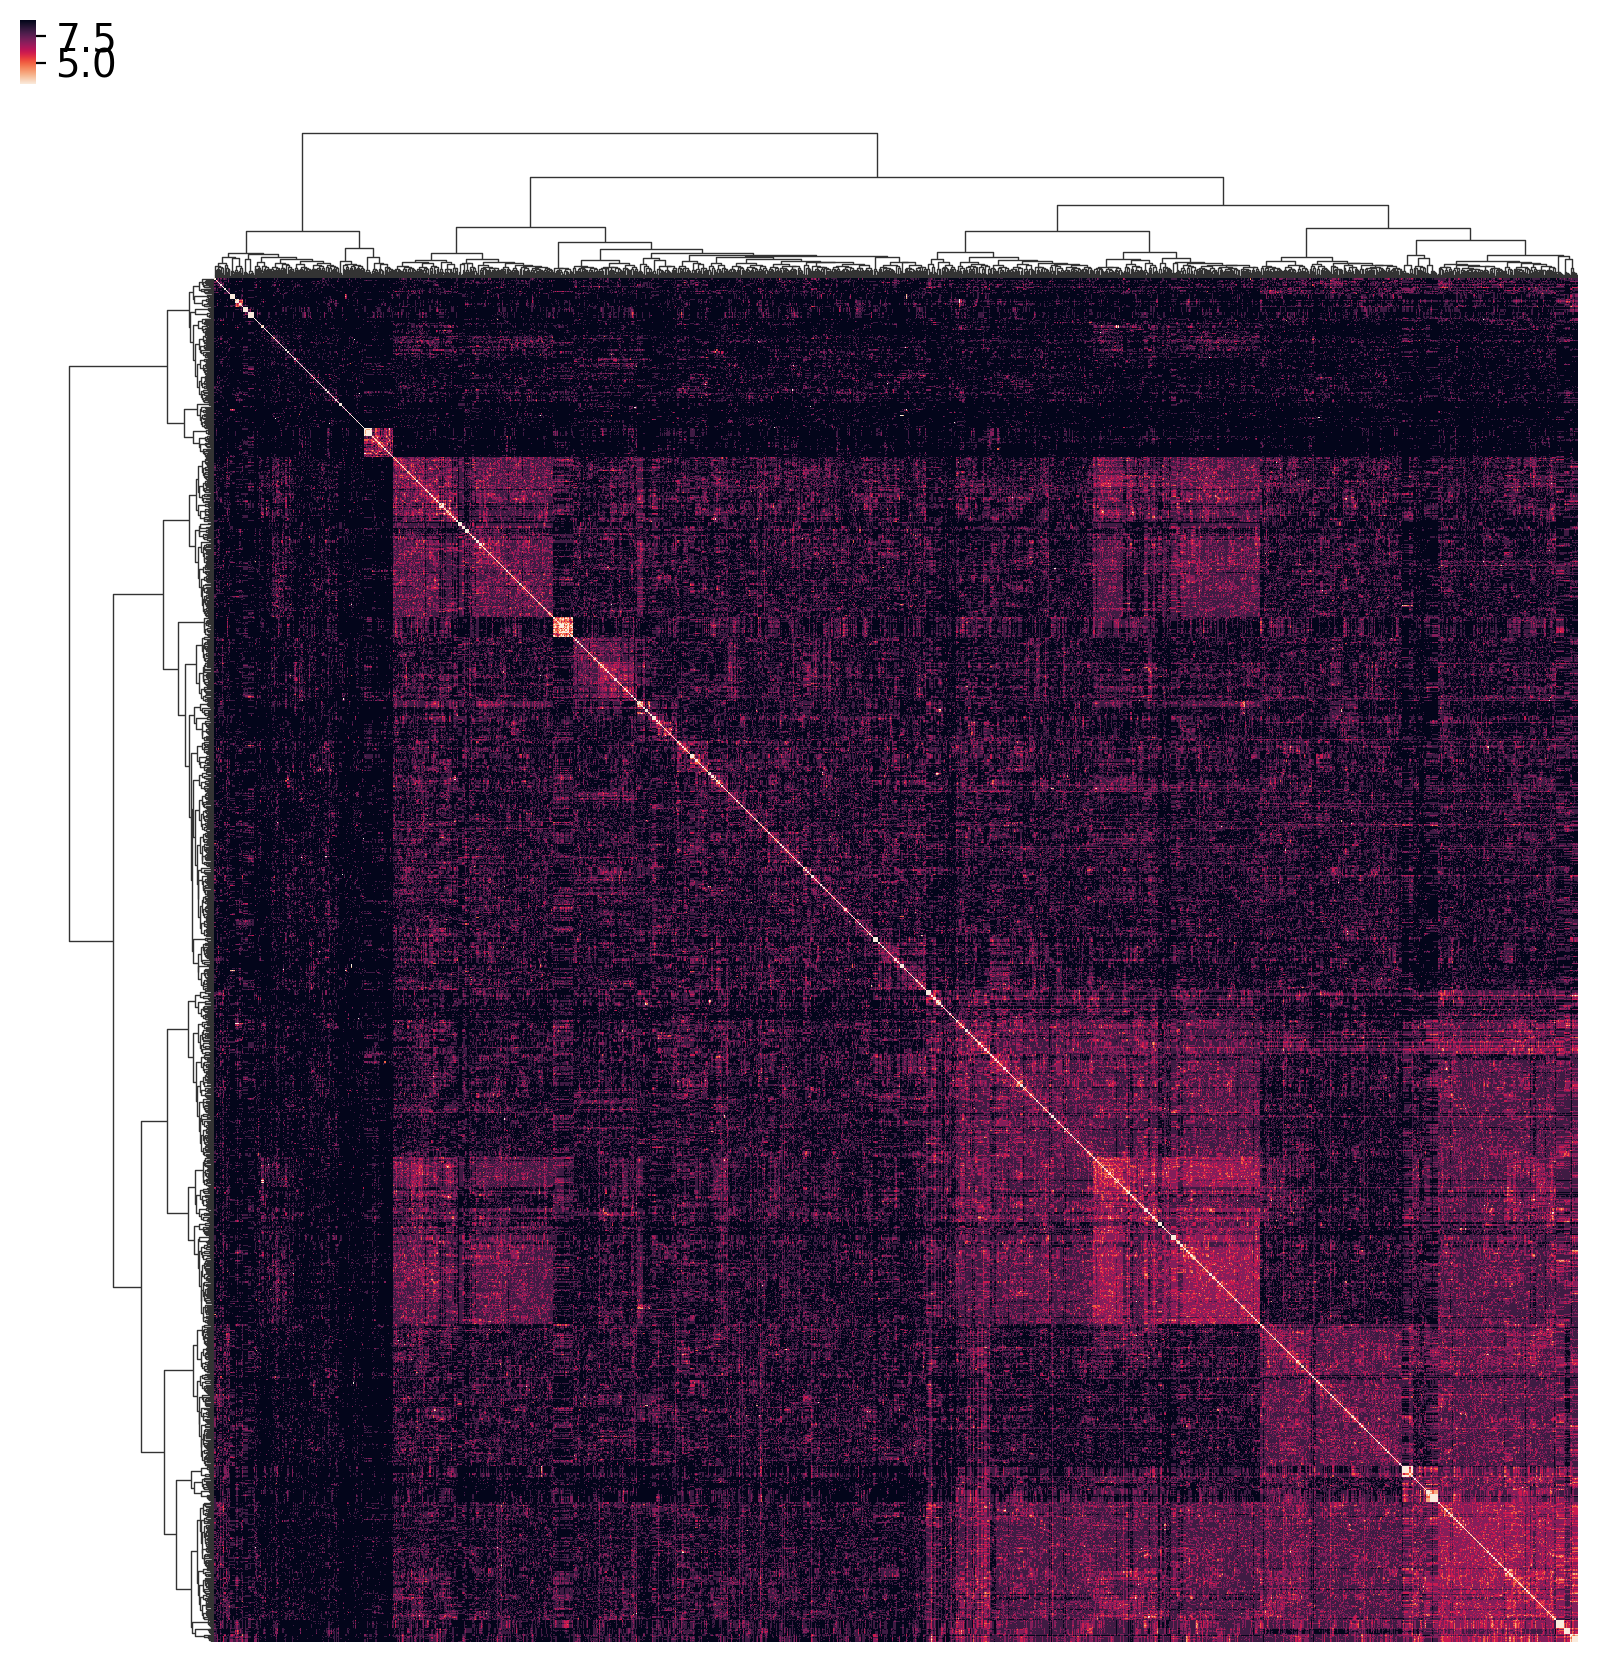

In [6]:
# plot levenshtein
sns.clustermap(df_l.astype(float), figsize=[8, 8], method='ward', xticklabels=0, yticklabels=0,
               dendrogram_ratio=.1, cbar_pos=(0, 1, .01, .04),
               vmin=3, vmax=9, cmap='rocket_r', row_linkage=Z, col_linkage=Z)

In [3]:
# set seed and identify irrelevant matches
np.random.seed(0)

# let's go through an example peptide
pep = df_l.index[0]

# read in the input peptide information
df = pd.read_csv('../outputs/model_v3/full.input.X.csv', index_col=0)
counts = df['Epitope'].value_counts()

# gather peptide cdr3 information
n_cdr3s = counts.loc[pep]
pep_cdr3s = df.loc[df['Epitope'] == pep, 'CDR3'].unique()

# we first grab the peptide levenshtein distances
pep_levenshtein = df_l[pep].sort_values()[::-1]
# systematically identify negative controls
irr_cdr3s = []
while n_cdr3s > 0:
    # then we look at the max distance, gather those peptides, randomly choose one
    # find associated CDR3s that don't overlap with the current peptide
    vmax = pep_levenshtein.max()
    irr_peps = pep_levenshtein.index[pep_levenshtein == vmax]
    # reset for the next round if needed
    pep_levenshtein = pep_levenshtein[pep_levenshtein < vmax]
    # find the irrelevant peptide CDR3s and make sure they don't overlap
    mask = (df['Epitope'].isin(irr_peps)) & (~df['CDR3'].isin(pep_cdr3s))
    if sum(mask) == 0:
        continue
    # if we have cdr3s then grab them out
    cdr3s = df.loc[mask, 'CDR3']
    # print out information, give three example irrelevant peptides, the distance, and total numbers
    print(vmax, np.random.choice(irr_peps, size=1, replace=False), len(irr_peps), len(cdr3s), n_cdr3s)
    # if there are more than we need randomly select
    if len(cdr3s) > n_cdr3s:
        irr_cdr3s += np.random.choice(cdr3s, size=n_cdr3s, replace=False).tolist()
        break
    # otherwise keep moving
    else:
        irr_cdr3s += cdr3s.tolist()
        n_cdr3s -= len(cdr3s)

# compile the full list
irr = pd.DataFrame(irr_cdr3s, columns=['CDR3'])
irr['Epitope'] = pep

11 ['NSFRPEVAMKY'] 7 36 16707
10 ['GTIRPEIREMW'] 83 8660 16671
9 ['GRVPLRAPK'] 443 19902 8011


In [4]:
# set seed to ensure replicability
np.random.seed(0)
# pull up an example of the most similar
vmin = pep_levenshtein[pep_levenshtein > 0].min()
np.random.choice(pep_levenshtein[pep_levenshtein == vmin].index, size=1)

array(['YLDELIRNT'], dtype=object)

In [5]:
# print out peptide to be checked against
pep

'YVLDHLIVV'

In [32]:
# now the reason we do this is because similar peptides are likely to bind to similar CDR3s
# we must exclude these peptides when we are selecting our negative controls
# in fact we want the most different peptides we can possibly get

In [29]:
from tqdm import tqdm
# set seed and identify irrelevant matches
np.random.seed(0)
irrs = []

for pep in tqdm(df_l.index):
    # gather peptide cdr3 information
    n_cdr3s = counts.loc[pep]
    pep_cdr3s = df.loc[df['Epitope'] == pep, 'CDR3'].unique()
    # we first grab the peptide levenshtein distances
    pep_levenshtein = df_l[pep].sort_values()[::-1]
    # systematically identify negative controls
    irr_cdr3s = []
    while n_cdr3s > 0:
        # then we look at the max distance, gather those peptides, randomly choose one
        # find associated CDR3s that don't overlap with the current peptide
        vmax = pep_levenshtein.max()
        irr_peps = pep_levenshtein.index[pep_levenshtein == vmax]
        # reset for the next round if needed
        pep_levenshtein = pep_levenshtein[pep_levenshtein < vmax]
        # find the irrelevant peptide CDR3s and make sure they don't overlap
        mask = (df['Epitope'].isin(irr_peps)) & (~df['CDR3'].isin(pep_cdr3s))
        if sum(mask) == 0:
            continue
        # if we have cdr3s then grab them out
        cdr3s = df.loc[mask, 'CDR3']
        # if there are more than we need randomly select
        if len(cdr3s) > n_cdr3s:
            irr_cdr3s += np.random.choice(cdr3s, size=n_cdr3s, replace=False).tolist()
            break
        # otherwise keep moving
        else:
            irr_cdr3s += cdr3s.tolist()
            n_cdr3s -= len(cdr3s)
    # compile the full list
    irr = pd.DataFrame(irr_cdr3s, columns=['CDR3'])
    irr['Epitope'] = pep
    irrs.append(irr)

100%|███████████████████████████████████████| 1576/1576 [00:42<00:00, 37.32it/s]


In [32]:
# gather irrelevant pairs
irr = pd.concat(irrs, axis=0)
# write the control input
irr.to_csv('../outputs/model_v3/full.control.X.csv')

In [102]:
from Levenshtein import distance
from tqdm import tqdm

# check all epitopes
epitopes = df['Epitope'].unique()
# create tracking dataframe for the values
df_stat = pd.DataFrame(columns=['posxpos','posxneg','negxneg'], index=epitopes)
# fill in statistics
for epitope in tqdm(df_stat.index):
    # try this a few times to get a good estimation
    posxposs, posxnegs, negxnegs = [], [], []

    # monte carlo simulation this
    for seed in range(10):
        # set the random seed
        np.random.seed(seed)

        # compare the average levenshtein distance
        pos_cdr3s = np.random.choice(df.loc[df['Epitope'] == epitope, 'CDR3'], size=100, replace=True)
        neg_cdr3s = np.random.choice(irr.loc[irr['Epitope'] == epitope, 'CDR3'], size=100, replace=True)

        # compute distances
        posxpos = []
        for idx, pep1 in enumerate(pos_cdr3s[:-1]):
            for pep2 in pos_cdr3s[idx+1:]:
                posxpos.append(distance(pep1, pep2))
        posxpos = np.mean(posxpos)

        posxneg = []
        for pep1 in pos_cdr3s:
            for pep2 in neg_cdr3s:
                posxneg.append(distance(pep1, pep2))
        posxneg = np.mean(posxneg)

        negxneg = []
        for idx, pep1 in enumerate(neg_cdr3s[:-1]):
            for pep2 in neg_cdr3s[idx+1:]:
                negxneg.append(distance(pep1, pep2))
        negxneg = np.mean(negxneg)

        # save the values
        posxposs.append(posxpos)
        posxnegs.append(posxneg)
        negxnegs.append(negxneg)
        
    # now add to dataframe
    df_stat.loc[epitope] = np.mean(posxposs), np.mean(posxnegs), np.mean(negxnegs)

100%|███████████████████████████████████████| 1576/1576 [09:08<00:00,  2.87it/s]


/tmp/ipykernel_22244/3069950459.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_22244/3069950459.py:9: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
/tmp/ipykernel_22244/3069950459.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,


0.0
7.079409697930402e-307
0.00047115267058563364


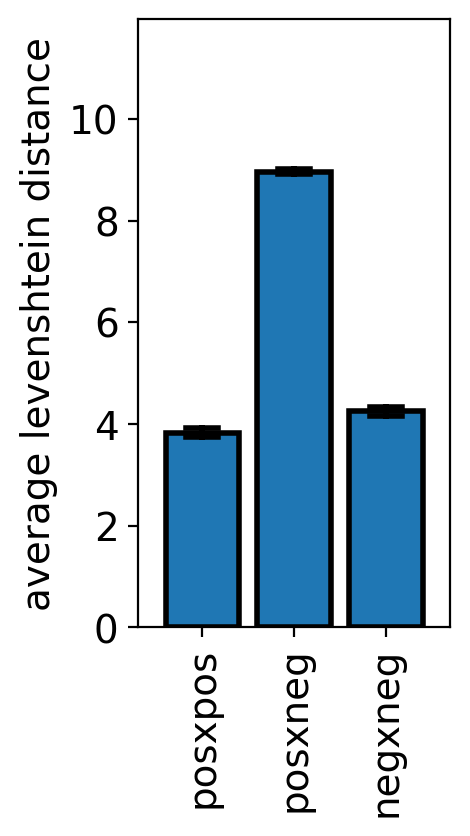

In [127]:
import scipy.stats as ss

# grab the data
plot = df_stat.melt()

# setup the barplots
fig, ax = plt.subplots(figsize=[2, 4])
ax.grid(False)
sns.barplot(x='variable', y='value', data=plot, ci=68, errwidth=2, capsize=0.35,
            saturation=1, edgecolor='k', linewidth=2, errcolor='k')
ax.tick_params(axis='x', labelrotation=90)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-0.2, xmax+0.2)
ax.set_xlabel('')
ax.set_ylabel('average levenshtein distance')
ymin, ymax = ax.get_ylim()
ax.set_ylim(0, ymax + 2.5)

print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'posxpos'].astype(float),
                   plot['value'][plot['variable'] == 'posxneg'].astype(float))[1])
print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'negxneg'].astype(float),
                   plot['value'][plot['variable'] == 'posxneg'].astype(float))[1])
print(ss.mannwhitneyu(plot['value'][plot['variable'] == 'posxpos'].astype(float),
                   plot['value'][plot['variable'] == 'negxneg'].astype(float))[1])

In [121]:
print(ss.normaltest(plot['value'].astype(float)))

NormaltestResult(statistic=1361.1599584763962, pvalue=2.67836969869947e-296)
